In [10]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter
import matplotlib
%matplotlib inline

## Data Cleaning:
Data cleaning and preparation; admittedly, this is not the most efficient code -- but it will produce what we want.

In [3]:
#Read in dataframe
df = pd.read_csv("data_train.csv")

#Steps to clean data by dropping columns where the number of empty rows is >= 445,000
dfComplete = df.dropna(1, thresh= 445000)
# dfComplete.shape #Results in (494932,58)

#Steps to clean data by dropping row where the number of empty columns is > 0
dfCompleteAll = dfComplete.dropna(0, how="any")
# dfCompleteAll.shape #results in a dataframe of (476155,58)

# dfCompleteAll.isnull().sum() #no more nulls in the dataset

y = dfCompleteAll[["ASOURCE", "ATYPE", "RACE", "TOTCHG", "ZIPINC_QRTL"]]

In [4]:
"""The next step is to prepare variables for exploratory data analysis and feature
selection using a random forest. 

Random forest does not require standardization of continuous variables or normalization
of discrete variable. For categorical features, we will need to use pd.get_dummies or 
one hot encoding to create binary dummy variables. 
"""

#First create two dataframes of int and float values to make things easier to work with 
columnNames = dfCompleteAll.columns
dfFloat = pd.DataFrame()
dfInt = pd.DataFrame()
for name in columnNames:
    if dfCompleteAll[name].dtype == float:
        dfFloat = dfFloat.join(dfCompleteAll[name], how = "right")
    else:
        dfInt = dfInt.join(dfCompleteAll[name], how = "right")
        
#Convert all columns in DfFloat, except DISCWT, to integer values. Afterwards nominal features
#will be one-hot encoded to create dummy variables, again we will not normalize or stadardize
# numeric values. 

float_toInt = ['AGE', 'AMONTH', 'AWEEKEND', 'DIED', 'DISPUNIFORM', 'DXCCS1',
       'DXCCS2', 'FEMALE', 'LOS', 'PAY1', 'HOSP_BEDSIZE', 'HOSP_CONTROL',
       'HOSP_LOCTEACH']

for digit in float_toInt:
    dfFloat[digit] = dfFloat[digit].astype(int)
    
# In dfFloat we have the following columns and feature groupings. 
# For reference use feature_desc or call .unique() method on one of the columns

# CONTINUOUS:
dfFloatContinuous = dfFloat[["AGE", "DISCWT"]]


# NOMINAL:
dfFloatNominal = dfFloat[['AMONTH', 'DISPUNIFORM', 'DXCCS1',
       'DXCCS2', 'PAY1', 'HOSP_CONTROL','HOSP_LOCTEACH']]

# BINARY & ORDINAL
dfBinaryOrdinal = dfFloat[["DIED", "AWEEKEND", "FEMALE", "HOSP_BEDSIZE"]]

# DISCRETE
dfDiscrete = dfFloat[["LOS"]]

In [5]:
#Use pd.get_dummies to turn nominal variables into dummy variables by first setting all 
#values as string, a requirement of pd.get_dummies. 

dfFloatNominal = dfFloatNominal.loc[:].astype(str)
    
dfFloatNominal = pd.get_dummies(dfFloatNominal)
dfFloatNominal.shape 

(475155, 556)

In [6]:
# We can now recreate the original dfFloat dataframe as dfFloatPreprocessed which 
# will have variables ready for feature selection with RF. Next the same thing must be down
#with dfInt
list_of_dataframes = [dfFloatContinuous, dfBinaryOrdinal, dfDiscrete, dfFloatNominal]

dfFloatPreprocessed = pd.DataFrame()
for frame in list_of_dataframes:
    dfFloatPreprocessed = dfFloatPreprocessed.join(frame, how = "right")
dfFloatPreprocessed.shape

(475155, 563)

In [7]:
#Prepare dfInt for preprocessing, starting with dropping respone variables
dfInt = dfInt.drop(["ASOURCE", "ATYPE", "RACE", "TOTCHG", "ZIPINC_QRTL"], axis= 1)

#CMs are all binary, therefore, create a separate dataframe for these columns: 
dfCm = dfInt[['CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF',
       'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG',
       'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY',
       'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE',
       'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL',
       'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS']]

#Update the dfInt dataframe to a new dataframe:
dfIntShort = dfInt.drop(['CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF',
       'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG',
       'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY',
       'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE',
       'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL',
       'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS'],axis = 1)

#Update the dfInt dataframe to a new dataframe:
dfIntShort = dfInt.drop(['CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF',
       'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG',
       'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY',
       'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE',
       'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL',
       'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS'],axis = 1)

#Since NDX, NPR, ORPROC, TOTAL_DISC are all either Binary or Discerete variables, create a separate dataframe
dfIntBinaryDiscrete = dfIntShort[["NDX", "NPR", "ORPROC", "TOTAL_DISC"]]

# Since DQTR, HOSPID, MDC, NIS_STRATUM, HOSP_REGION are all nominal variables, create a separate dataframe to 
#turn these into dummy variables. ALSO Drop "KEY" as this is the record id field: 
dfIntToDummies = dfIntShort.drop(["KEY", "NDX", "NPR", "ORPROC", "TOTAL_DISC"], axis= 1)

#Turn values in DQTR, HOSPID, MDC, NIS_STRATUM, HOSP_REGION to string
dfIntToDummies = dfIntToDummies.loc[:].astype(str)

#Use pd.get_dummies to turn nominal string values to binary dummy variables
dfIntToDummies = pd.get_dummies(dfIntToDummies)
# dfIntToDummies.head()

intRecombine = [dfIntToDummies, dfCm, dfIntBinaryDiscrete]

dfIntPreprocessed = pd.DataFrame()
for df in intRecombine:
    dfIntPreprocessed = dfIntPreprocessed.join(df, how = "right")
    
dfPreprocessed = dfFloatPreprocessed.join(dfIntPreprocessed, how = "right")

In [8]:
#plug these dfs back together
dfFull = pd.concat([dfPreprocessed, y], axis=1)

## Check Outcome Variable Distribution
- Total Charges (TOTCHG) is a special case, as it is continuous. We're going to break it into quartiles and use a random forest classifier.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ccc7668>]], dtype=object)

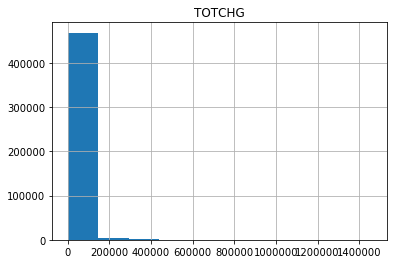

In [11]:
dfFull.hist(column='TOTCHG')

In [13]:
#yikes- some outliers
pd.set_option('display.float_format', lambda x: '%.3f' % x) #I hate scientific notation for manageable numbers
dfFull.TOTCHG.describe()

count    475155.000
mean      23158.186
std       38689.596
min         101.000
25%        6286.000
50%       12337.000
75%       25708.000
max     1461234.000
Name: TOTCHG, dtype: float64

In [15]:
#establish our bins; they are not uniform, because total charges has some interesting outliers we can try to predict
labels = ['1', '2', '3', '4', '5'] #just class labels we'll call 1-5
bins = [0, 1000, 5000, 10000, 20000, 1500000]

dfFull = dfFull.assign(TOTCHG_CATS = pd.cut(dfFull.TOTCHG, bins, labels=labels)) #add a new column with our cuts

In [16]:
dfFull.TOTCHG_CATS.value_counts()

5    157053
4    117486
3    116383
2     81034
1      3199
Name: TOTCHG_CATS, dtype: int64

In [39]:
dfFull.TOTCHG_CATS.value_counts(normalize=True)

5   0.331
4   0.247
3   0.245
2   0.171
1   0.007
Name: TOTCHG_CATS, dtype: float64

I guess low charges are going to be our outliers. Such is the American health care system.

In [19]:
dfFull.head()

,AGE,DISCWT,DIED,AWEEKEND,FEMALE,HOSP_BEDSIZE,LOS,AMONTH_1,AMONTH_10,AMONTH_11,...,NDX,NPR,ORPROC,TOTAL_DISC,ASOURCE,ATYPE,RACE,TOTCHG,ZIPINC_QRTL,TOTCHG_CATS
0,48,4.671,0,0,0,1,83,0,0,1,...,18,7,1,409,2,2,1,272123,3,5
1,66,4.671,0,0,0,1,50,0,0,1,...,18,8,0,409,2,2,1,209246,1,5
2,53,4.671,0,0,0,1,65,0,0,1,...,18,6,0,409,2,2,1,305474,1,5
3,27,4.671,0,0,1,1,59,0,0,1,...,18,4,0,409,2,2,1,202973,1,5
4,48,4.671,1,0,0,1,77,0,0,1,...,18,8,0,409,2,2,1,416072,1,5


## Model Fitting
- We are going to use a Random Forest and optimize its parameters.

### Train Test Split

In [22]:
X = dfFull.drop(['TOTCHG', 'TOTCHG_CATS'], axis=1) #have to remember to drop both or we'd be very accurate.....
y = dfFull.TOTCHG_CATS

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 12)

## "Base" Model Random Forest
- In reality, this base model isn't at all a blind stab; we have methodically tuned Random Forests to predict other outcome variables in this dataset, and **we're starting with ideal parameters for models that imputed RACE, ASOURCE, etc.** (See the accompanying .ipynb "HCUP_Imputation_RF_Undersample_RACE_ZIPINCQRTL" for details).
- We will perform **additional tuning to see if it can improve this base model.**

In [25]:
base_rfc = RandomForestClassifier(n_jobs=-1,max_features=100,n_estimators=300,max_depth=250,min_samples_split=5,
                             min_samples_leaf=1,oob_score = True,random_state=12)

base_rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=250, max_features=100, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=True, random_state=12, verbose=0, warm_start=False)

In [26]:
base_rfc_predictions = base_rfc.predict(X_test)
base_rfc_accuracy = accuracy_score(y_test, base_rfc_predictions)
base_rfc_accuracy

0.79148742728703836

In [27]:
base_rfc_report = classification_report(y_test, base_rfc_predictions)
print(base_rfc_report)

             precision    recall  f1-score   support

          1       0.80      0.61      0.69       767
          2       0.84      0.80      0.82     20435
          3       0.72      0.75      0.73     29057
          4       0.70      0.70      0.70     29322
          5       0.89      0.89      0.89     39208

avg / total       0.79      0.79      0.79    118789



In [28]:
pd.crosstab(y_test, base_rfc_predictions, 
            rownames=['Actual TOTCHG_CAT'], colnames=['Predicted TOTCHG_CAT'])

Predicted TOTCHG_CAT,1,2,3,4,5
Actual TOTCHG_CAT,,,,,
1,465,291,8,1,2
2,114,16382,3730,196,13
3,1,2629,21773,4485,169
4,1,210,4670,20485,3956
5,0,16,207,4070,34915


Nice F-1 scores. And as we can see from crosstabs, when this classifier misses, it tends to miss to the classes "next" to it (that is, the classes of quantitative charges closest to it). This is a good classifier.

**But let's see if we can improve it**.

## Cross Validation

Computationally, we can't handle doing a grid search on all our data. So let's try about 1/10 of the full training portion.

In [31]:
sample = dfFull.sample(n=30000)
X_sample = sample.drop(['TOTCHG', 'TOTCHG_CATS'], axis=1)
y_sample = sample.TOTCHG_CATS

X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, 
                                                                                test_size = 0.25, random_state=12)

In [32]:
y_sample.value_counts()

5    10019
4     7431
3     7214
2     5134
1      202
Name: TOTCHG_CATS, dtype: int64

The risk here is there's not enough class 1 data for the models to "see", and that we are optimizing this on what's really a different dataset. But, it's the best we can pull off with computational limitations! **This is why we have a "base" classifier (which is actually quite good) to compare to**.

In [33]:
#pick our params; from (bad) experience, my machine can handle about 7 different params
param_grid = {
    'min_samples_split': [2, 5, 10, 25],
    'max_features': ['auto', 100, 300]
}

rfc_CV = GridSearchCV(estimator=base_rfc, param_grid=param_grid, scoring='f1_micro', 
                      n_jobs=-1, return_train_score=False)

rfc_CV.fit(X_sample_train, y_sample_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=250, max_features=100, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=True, random_state=12, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [2, 5, 10, 25], 'max_features': ['auto', 100, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1_micro', verbose=0)

In [34]:
rfc_CV.best_params_

{'max_features': 300, 'min_samples_split': 2}

## "Best Params" Random Forest
- Remember, it's entirely possible this will not improve results, as the CV was biased by computational necessity.
- Then again, it could have provided valuable insight. We'll see!

In [36]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size = 0.45, random_state = 12)

rfc_tuned = RandomForestClassifier(n_jobs=-1,max_features=300,n_estimators=300,max_depth=250,min_samples_split=2,
                             min_samples_leaf=1,oob_score = True,random_state=12)

rfc_tuned.fit(X_train_new, y_train_new)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=250, max_features=300, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=True, random_state=12, verbose=0, warm_start=False)

In [37]:
rfc_tuned_predictions = rfc_tuned.predict(X_test)
rfc_tuned_accuracy = accuracy_score(y_test, rfc_tuned_predictions)
rfc_tuned_accuracy

0.78938285531488606

In [38]:
rfc_tuned_report = classification_report(y_test, rfc_tuned_predictions)
print(rfc_tuned_report)

             precision    recall  f1-score   support

          1       0.77      0.62      0.68       767
          2       0.83      0.81      0.82     20435
          3       0.71      0.74      0.73     29057
          4       0.70      0.70      0.70     29322
          5       0.90      0.89      0.89     39208

avg / total       0.79      0.79      0.79    118789



 We really see no improvement. In fact, **with random variation, the "tuned" model is a bit worse on certain f-1 scores**. 
 
### We should stay with the more conventional base model (which is in fact quite good).
 
 **"Base" Model**
 
 **Accuracy: ~79.14%**
    
             precision    recall  f1-score   support

          1       0.80      0.61      0.69       767
          2       0.84      0.80      0.82     20435
          3       0.72      0.75      0.73     29057
          4       0.70      0.70      0.70     29322
          5       0.89      0.89      0.89     39208

        avg / total       0.79      0.79      0.79    118789

**"Tuned" Model**

**Accuracy: ~78.94%**

             precision    recall  f1-score   support

          1       0.77      0.62      0.68       767
          2       0.83      0.81      0.82     20435
          3       0.71      0.74      0.73     29057
          4       0.70      0.70      0.70     29322
          5       0.90      0.89      0.89     39208

        avg / total       0.79      0.79      0.79    118789